In [1]:
import os
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

# JSON 기반 데이터 스키마 생성 및 관리(검증, 업데이트 등)에 사용되는 Python 패키지로, 현재 AI/에이전트 시스템에서 많이 사용됨
from trustcall import create_extractor

load_dotenv()
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

### Memory Extractor Test

Test Conversations

In [2]:
# Conversation
conversation = [HumanMessage(content="Hi, I'm Changwoo."), 
                AIMessage(content="Nice to meet you, Changwoo."), 
                HumanMessage(content="I'm 29 years old, and i have been studying Artificial Intelligence")]

# Run
MESSAGE = [SystemMessage(content="Extract memories from the following conversation:")] + conversation

Define Tool and Model, then Invoke

In [3]:
class MemoryTool(BaseModel):
    """
        Des:
            Tool for Long Term Memory
            -> 'responses': [MemoryTool(content=...)]
    """
    content: str = Field(description="The main content of the memory. For example: User expressed interest in learning about French.")
    # content: str = Field(description="The main content of the memory. For example: [Name]:Minsu, [Age]:35")
    
model = ChatOpenAI(model="gpt-4o", temperature=0)
memory_extractor = create_extractor(
    model, # language model
    tools=[MemoryTool], # tool list for extraction
    tool_choice="MemoryTool", # prioritized tool
    enable_inserts=True, # enable insert mode (update existing memory, create new memory)
)

result = memory_extractor.invoke({"messages": MESSAGE})
result

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_OWSJgjeUGmUAMtu6ilq3aMKA', 'function': {'arguments': '{"content":"Changwoo is 29 years old and has been studying Artificial Intelligence."}', 'name': 'MemoryTool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 155, 'total_tokens': 173, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_831e067d82', 'finish_reason': 'stop', 'logprobs': None}, id='run-4f128dc4-8fa6-480c-b971-d9548ccc9b36-0', tool_calls=[{'name': 'MemoryTool', 'args': {'content': 'Changwoo is 29 years old and has been studying Artificial Intelligence.'}, 'id': 'call_OWSJgjeUGmUAMtu6ilq3aMKA', 'type': 'tool_call'}], usage_metadata={'input_tokens': 155, 'outpu

Add Conversations

In [4]:
# New Conversation
updated_conversation = [AIMessage(content="That's great, by the way, what is your hobby?"), 
                        HumanMessage(content="My hobby is working out in the gym."),                        
                        AIMessage(content="Sounds good, Do you have any plans for the weekend?"),
                        HumanMessage(content="I'm thinking about going to the parent's house to help them prepare for the restaurant."),]

# Previous Memories
existing_memories = []
for i, memory in enumerate(result["responses"]):
    existing_memories.append((str(i), "MemoryTool", memory.model_dump()))
print("==== Previous Memories ====")
print(existing_memories)

==== Previous Memories ====
[('0', 'MemoryTool', {'content': 'Changwoo is 29 years old and has been studying Artificial Intelligence.'})]


In [5]:
class Spy:
    '''
        Des:
            monitor and collect information about the tool calls
    '''
    def __init__(self):
        '''Initialize a list of tools that were called during execution'''
        self.called_tools = []

    def __call__(self, run):
        '''Collect information about the tool calls made by the extractor.'''
        q = [run]
        while q:
            r = q.pop()
            if r.child_runs:
                q.extend(r.child_runs)
            if r.run_type == "chat_model":
                self.called_tools.append(
                    r.outputs["generations"][0][0]["message"]["kwargs"]["tool_calls"]
                )

spy = Spy()
tool_call_tracker = memory_extractor.with_listeners(on_end=spy)
# tool_call_tracker = memory_extractor.with_listeners()

In [6]:
result = tool_call_tracker.invoke({"messages": updated_conversation, 
                                   "existing": existing_memories,})
result

{'messages': [AIMessage(content='', additional_kwargs={'updated_docs': {'call_yTdio7dx0F58UqeBmLUFOjkQ': '0'}}, response_metadata={}, id='1e1fe3cc-cd7a-4b2e-84c8-bba45f7e3ae5', tool_calls=[{'name': 'MemoryTool', 'args': {'content': "Changwoo is 29 years old and has been studying Artificial Intelligence. His hobby is working out in the gym. He plans to go to his parent's house this weekend to help them prepare for the restaurant."}, 'id': 'call_yTdio7dx0F58UqeBmLUFOjkQ', 'type': 'tool_call'}, {'name': 'MemoryTool', 'args': {'content': "User's hobby is working out in the gym."}, 'id': 'call_s6XGIljw2Gjt8x3qmbwDIuBB', 'type': 'tool_call'}, {'name': 'MemoryTool', 'args': {'content': "User plans to go to their parent's house this weekend to help them prepare for the restaurant."}, 'id': 'call_TYC81crakZrhIbRgIovSNT2a', 'type': 'tool_call'}])],
 'responses': [MemoryTool(content="Changwoo is 29 years old and has been studying Artificial Intelligence. His hobby is working out in the gym. He pl

In [7]:
# Inspect the tool calls result
spy.called_tools

[[{'name': 'PatchDoc',
   'args': {'json_doc_id': '0',
    'planned_edits': "Update the existing MemoryTool instance to include the user's hobby and weekend plans. The content field should reflect these new details.",
    'patches': [{'op': 'replace',
      'path': '/content',
      'value': "Changwoo is 29 years old and has been studying Artificial Intelligence. His hobby is working out in the gym. He plans to go to his parent's house this weekend to help them prepare for the restaurant."}]},
   'id': 'call_yTdio7dx0F58UqeBmLUFOjkQ',
   'type': 'tool_call'},
  {'name': 'MemoryTool',
   'args': {'content': "User's hobby is working out in the gym."},
   'id': 'call_s6XGIljw2Gjt8x3qmbwDIuBB',
   'type': 'tool_call'},
  {'name': 'MemoryTool',
   'args': {'content': "User plans to go to their parent's house this weekend to help them prepare for the restaurant."},
   'id': 'call_TYC81crakZrhIbRgIovSNT2a',
   'type': 'tool_call'}]]

In [8]:
def extract_tool_info(tool_calls, 
                      schema_name):
    """
        Des:
            Extract information from tool calls for both patches and new memories.

        Args:
            tool_calls: List of tool calls from the model
            schema_name: Name of the schema tool (e.g., "MemoryTool", "ToDo", "ProfileTool")
    """
    # Initialize list of changes
    changes = []
    
    # Iterate through tool calls and check changes
    for call_group in tool_calls:
        for call in call_group:
            if call['name'] == 'PatchDoc': # Update memory
                changes.append({
                    'type': 'update',
                    'doc_id': call['args']['json_doc_id'],
                    'planned_edits': call['args']['planned_edits'],
                    'value': call['args']['patches'][0]['value']
                })
            elif call['name'] == schema_name: # Add new memory
                changes.append({
                    'type': 'new',
                    'value': call['args']
                })
    
    # Format results as a single string
    result_parts = []
    for change in changes:
        if change['type'] == 'update':
            result_parts.append(
                f"Document {change['doc_id']} updated:\n"
                f"Plan: {change['planned_edits']}\n"
                f"Added content: {change['value']}"
            )
        else:
            result_parts.append(
                f"New {schema_name} created:\n"
                f"Content: {change['value']}"
            )
    
    return "\n\n".join(result_parts)

schema_name = "MemoryTool"
changes = extract_tool_info(spy.called_tools, schema_name)
print(changes)

Document 0 updated:
Plan: Update the existing MemoryTool instance to include the user's hobby and weekend plans. The content field should reflect these new details.
Added content: Changwoo is 29 years old and has been studying Artificial Intelligence. His hobby is working out in the gym. He plans to go to his parent's house this weekend to help them prepare for the restaurant.

New MemoryTool created:
Content: {'content': "User's hobby is working out in the gym."}

New MemoryTool created:
Content: {'content': "User plans to go to their parent's house this weekend to help them prepare for the restaurant."}


## Todo List Agent

In [9]:
from typing import TypedDict, Literal
import uuid
from IPython.display import Image, display
from datetime import datetime
from trustcall import create_extractor
from typing import Optional
from pydantic import BaseModel, Field
from langchain_core.runnables import RunnableConfig
from langchain_core.messages import merge_message_runs, HumanMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, END, START
from langgraph.store.base import BaseStore
from langgraph.store.memory import InMemoryStore
from langchain_openai import ChatOpenAI

Define Tools

In [10]:
class UpdateMemoryTool(TypedDict):
    """
        Des:
            Decision on what memory type to update 
            -> option 1 : user (semantic memory)
            -> option 2 : todo (episodic memory)
            -> option 3 : instructions (procedural memory)
            -> 'responses': [MemoryTool(content=...)]
    """
    update_type: Literal['user', 'todo', 'instructions']
    
class ProfileTool(BaseModel):
    """
        Des:
            The profile of the user
    """
    name: Optional[str] = Field(description="The user's name", default=None)
    location: Optional[str] = Field(description="The user's location", default=None)
    job: Optional[str] = Field(description="The user's job", default=None)
    connections: list[str] = Field(
        description="Personal connection of the user, such as family members, friends, or coworkers",
        default_factory=list
    )
    interests: list[str] = Field(
        description="Interests that the user has", 
        default_factory=list
    )
    
class ToDoTool(BaseModel):
    task: str = Field(description="The task to be completed.")
    time_to_complete: Optional[int] = Field(description="Estimated time to complete the task (minutes).")
    deadline: Optional[datetime] = Field(
        description="When the task needs to be completed by (if applicable)",
        default=None
    )
    solutions: list[str] = Field(
        description="List of specific, actionable solutions (e.g., specific ideas, service providers, or concrete options relevant to completing the task)",
        min_items=1,
        default_factory=list
    )
    status: Literal["not started", "in progress", "done", "archived"] = Field(
        description="Current status of the task",
        default="not started"
    )

Define Prompts

In [11]:
# Role : Chatbot System Message (Chatbot Behavior Guidelines)
MODEL_SYSTEM_MESSAGE = """You are a helpful chatbot. 

You are designed to be a companion to a user, helping them keep track of their ToDo list.

You have a long term memory which keeps track of three things:
1. The user's profile (general information about them) 
2. The user's ToDo list
3. General instructions for updating the ToDo list

Here is the current User Profile (may be empty if no information has been collected yet):
<user_profile>
{user_profile}
</user_profile>

Here is the current ToDo List (may be empty if no tasks have been added yet):
<todo>
{todo}
</todo>

Here are the current user-specified preferences for updating the ToDo list (may be empty if no preferences have been specified yet):
<instructions>
{instructions}
</instructions>

Here are your instructions for reasoning about the user's messages:

1. Reason carefully about the user's messages as presented below. 

2. Decide whether any of the your long-term memory should be updated:
- If personal information was provided about the user, update the user's profile by calling UpdateMemoryTool tool with type `user`
- If tasks are mentioned, update the ToDo list by calling UpdateMemoryTool tool with type `todo`
- If the user has specified preferences for how to update the ToDo list, update the instructions by calling UpdateMemoryTool tool with type `instructions`

3. Tell the user that you have updated your memory, if appropriate:
- Do not tell the user you have updated the user's profile
- Tell the user them when you update the todo list
- Do not tell the user that you have updated instructions

4. Err on the side of updating the todo list. No need to ask for explicit permission.

5. Respond naturally to user user after a tool call was made to save memories, or if no tool call was made."""


# Role : Select Information to retain about the User (Profile and ToDo)
MEMORY_SELECTION_INSTRUCTION = """Reflect on following interaction. 

Use the provided tools to retain any necessary memories about the user. 

Use parallel tool calling to handle updates and insertions simultaneously.

System Time: {time}"""

# Role : Update Instructions
CREATE_INSTRUCTIONS = """Reflect on the following interaction.

Based on this interaction, update your instructions for how to update ToDo list items. 

Use any feedback from the user to update how they like to have items added, etc.

Your current instructions are:

<current_instructions>
{current_instructions}
</current_instructions>"""

Define Agent (Node)

In [12]:
def task_mAIstro(state: MessagesState, 
                 config: RunnableConfig, 
                 store: BaseStore):
    """
        Des:
            Agent for chatbot
    """
    
    # Get the user ID from the config
    USER_ID = config["configurable"]["user_id"]

    # Retrieve profile memory from the store
    NAMESPACE = ("profile", USER_ID)
    memories = store.search(NAMESPACE)
    if memories:
        user_profile = memories[0].value
    else:
        user_profile = None

    # Retrieve task memory from the store
    NAMESPACE = ("todo", USER_ID)
    memories = store.search(NAMESPACE)
    todo = "\n".join(f"{mem.value}" for mem in memories)

    # Retrieve custom instructions
    NAMESPACE = ("instructions", USER_ID)
    memories = store.search(NAMESPACE)
    if memories:
        instructions = memories[0].value
    else:
        instructions = ""
    
    SYSTEM_MESSAGE = MODEL_SYSTEM_MESSAGE.format(user_profile=user_profile, todo=todo, instructions=instructions)
    MESSAGE = [SystemMessage(content=SYSTEM_MESSAGE)] + state["messages"]
    response = model.bind_tools([UpdateMemoryTool], 
                                parallel_tool_calls=False).invoke(MESSAGE)

    return {"messages": [response]}

Define other Nodes and Functions

In [13]:
def update_profile(state: MessagesState, 
                   config: RunnableConfig, 
                   store: BaseStore):
    """
        Des:
            Update Profile Memory
    """
    # Get the user ID from the config
    USER_ID = config["configurable"]["user_id"]

    # Define the namespace for the memories
    NAMESPACE = ("profile", USER_ID)
    
    # Memories
    memories = store.search(NAMESPACE)
    existing_memories = []
    if memories:
        for memory in memories:
            existing_memories.append((memory.key, "ProfileTool", memory.value))
    else:
        existing_memories = None

    # Current Message
    SYSTEM_MESSAGE=MEMORY_SELECTION_INSTRUCTION.format(time=datetime.now().isoformat())
    MESSAGE = [SystemMessage(content=SYSTEM_MESSAGE)] + state["messages"][:-1]
    MESSAGE=list(merge_message_runs(messages=MESSAGE))

    profile_extractor = create_extractor(
        model,
        tools=[ProfileTool],
        tool_choice="ProfileTool",
    )

    # Invoke the extractor
    result = profile_extractor.invoke({"messages": MESSAGE, 
                                       "existing": existing_memories})

    # Save the memories
    for response, response_metadata in zip(result["responses"], result["response_metadata"]):
        store.put(NAMESPACE,
                  response_metadata.get("json_doc_id", str(uuid.uuid4())),
                  response.model_dump(mode="json"))

    # Respond to the tool call made in task_mAIstro, confirming the update
    tool_calls = state['messages'][-1].tool_calls
    return {"messages": [{"role": "tool", 
                          "content": "updated profile", 
                          "tool_call_id":tool_calls[0]['id']}]}


def update_todos(state: MessagesState, 
                 config: RunnableConfig, 
                 store: BaseStore):
    """
        Des:
            Update ToDo Memory
    """
    # Get the user ID from the config
    USER_ID = config["configurable"]["user_id"]

    # Define the namespace for the memories
    NAMESPACE = ("todo", USER_ID)

    # Memories
    memories = store.search(NAMESPACE)
    
    if memories:
        existing_memories = []
        for memory in memories:
            existing_memories.append((memory.key, "ToDoTool", memory.value))
    else:
        existing_memories = None

    # Merge the chat history and the instruction
    SYSTEM_MESSAGE=MEMORY_SELECTION_INSTRUCTION.format(time=datetime.now().isoformat())
    MESSAGE = [SystemMessage(content=SYSTEM_MESSAGE)] + state["messages"][:-1]
    MESSAGE=list(merge_message_runs(messages=MESSAGE))

    # Create the Trustcall extractor for updating the ToDo list 
    spy = Spy()
    todo_extractor = create_extractor(
        model,
        tools=[ToDoTool],   
        tool_choice="ToDoTool",
        enable_inserts=True
    ).with_listeners(on_end=spy)

    # Invoke the extractor
    result = todo_extractor.invoke({"messages": MESSAGE, 
                                    "existing": existing_memories})

    # Save the memories from Trustcall to the store
    for response, response_metadata in zip(result["responses"], result["response_metadata"]):
        store.put(NAMESPACE,
                  response_metadata.get("json_doc_id", str(uuid.uuid4())),
                  response.model_dump(mode="json"),
            )
        
    # Respond to the tool call made in task_mAIstro, confirming the update
    tool_calls = state['messages'][-1].tool_calls

    # Message to task_mAIstro for changes
    todo_update_msg = extract_tool_info(spy.called_tools, "ToDoTool")
    return {"messages": [{"role": "tool", 
                          "content": todo_update_msg, 
                          "tool_call_id":tool_calls[0]['id']}]}

def update_instructions(state: MessagesState, 
                        config: RunnableConfig, 
                        store: BaseStore):
    """
        Des:
            Update Instructions
    """
    
    # Get the user ID from the config
    USER_ID = config["configurable"]["user_id"]
    
    # Define the namespace for the memories
    NAMESPACE = ("instructions", USER_ID)

    existing_memory = store.get(NAMESPACE, "user_instructions")
        
    # Format the memory in the system prompt
    SYSTEM_MESSAGE = CREATE_INSTRUCTIONS.format(current_instructions=existing_memory.value if existing_memory else None)
    MESSAGE = [SystemMessage(content=SYSTEM_MESSAGE)] + state["messages"][:-1] + [HumanMessage(content="Please update the instructions based on the conversation")]
    response = model.invoke(MESSAGE)

    # Overwrite the existing memory in the store 
    key = "user_instructions"
    store.put(NAMESPACE, key, {"memory": response.content})
    
    # Respond to the tool call made in task_mAIstro, confirming the update
    tool_calls = state['messages'][-1].tool_calls
    return {"messages": [{"role": "tool", 
                          "content": "updated instructions", 
                          "tool_call_id":tool_calls[0]['id']}]}

Define Edge

In [14]:
def route_message(state: MessagesState, 
                  config: RunnableConfig, 
                  store: BaseStore) -> Literal[END, "update_todos", "update_instructions", "update_profile"]:
    """
        Des:
            Route the message to the appropriate node based on the tool call
    """
    message = state['messages'][-1]
    if len(message.tool_calls) ==0:
        return END
    else:
        tool_call = message.tool_calls[0]
        if tool_call['args']['update_type'] == "user":
            return "update_profile"
        elif tool_call['args']['update_type'] == "todo":
            return "update_todos"
        elif tool_call['args']['update_type'] == "instructions":
            return "update_instructions"
        else:
            raise ValueError

Define Graph

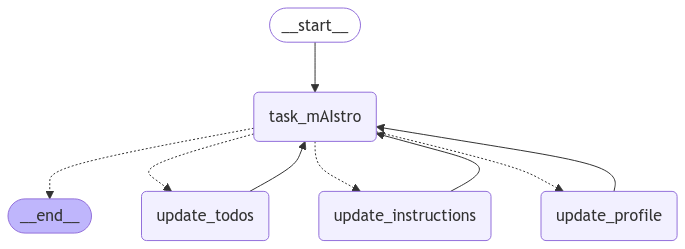

In [15]:
# Create the graph + all nodes
builder = StateGraph(MessagesState)

# Define the flow of the memory extraction process
builder.add_node(task_mAIstro)
builder.add_node(update_todos)
builder.add_node(update_profile)
builder.add_node(update_instructions)

builder.add_edge(START, "task_mAIstro")
builder.add_conditional_edges("task_mAIstro", route_message)
builder.add_edge("update_todos", "task_mAIstro")
builder.add_edge("update_profile", "task_mAIstro")
builder.add_edge("update_instructions", "task_mAIstro")

# Store for long-term (across-thread) memory
LongTermMemory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
ShortTermMemory = MemorySaver()

# We compile the graph with the checkpointer and store
graph = builder.compile(checkpointer=ShortTermMemory, 
                        store=LongTermMemory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

## Chat Test

Set Configuration

In [16]:
THREAD_ID = "3"
USER_ID = "changwoo_test1"
config = {"configurable": {"thread_id": THREAD_ID, 
                           "user_id": USER_ID}}

Chat (1) Create Profile

In [17]:
MESSAGE = [HumanMessage(content="My name is changwoo. I live in Busan, and I'm 29 years old")]
for chunk in graph.stream({"messages":MESSAGE}, 
                          config, 
                          stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

My name is changwoo. I live in Busan, and I'm 29 years old
================================== Ai Message ==================================
Tool Calls:
  UpdateMemoryTool (call_zzp3jH0IUEuh7Jv5fkpVHBV8)
 Call ID: call_zzp3jH0IUEuh7Jv5fkpVHBV8
  Args:
    update_type: user
================================= Tool Message =================================

updated profile
================================== Ai Message ==================================

Got it! If there's anything else you'd like to share or need help with, feel free to let me know.


Chat (2) Create ToDo

In [18]:
MESSAGE = [HumanMessage(content="I have to buy a new filter for my water dispenser.")]
for chunk in graph.stream({"messages":MESSAGE}, 
                          config, 
                          stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I have to buy a new filter for my water dispenser.


================================== Ai Message ==================================
Tool Calls:
  UpdateMemoryTool (call_nFvaDt7WkvnMOqidkbCPA8cw)
 Call ID: call_nFvaDt7WkvnMOqidkbCPA8cw
  Args:
    update_type: todo
================================= Tool Message =================================

New ToDoTool created:
Content: {'task': 'Buy a new filter for the water dispenser', 'time_to_complete': 30, 'solutions': ['Check local appliance stores in Busan', 'Look for online options like Amazon or local e-commerce sites', "Contact the water dispenser's manufacturer for compatible filters"], 'status': 'not started'}
================================== Ai Message ==================================

I've added "Buy a new filter for the water dispenser" to your ToDo list. If you need any help with this task, just let me know!


Chat (3) Update Instructions

In [19]:
MESSAGE = """When creating or updating them, 
start the sentence with key terms/words enclosed in square brackets ([, ]).

For Example,

If Taks is 'I check the train scedule in this week', then

ToDo is '[train scedule]:Check the train scedule in this week'"""

for chunk in graph.stream({"messages": MESSAGE}, 
                          config, 
                          stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

When creating or updating them, 
start the sentence with key terms/words enclosed in square brackets ([, ]).

For Example,

If Taks is 'I check the train scedule in this week', then

ToDo is '[train scedule]:Check the train scedule in this week'
================================== Ai Message ==================================
Tool Calls:
  UpdateMemoryTool (call_A6sgrOytn36kHS2IJhOH57Xk)
 Call ID: call_A6sgrOytn36kHS2IJhOH57Xk
  Args:
    update_type: instructions
================================= Tool Message =================================

updated instructions
================================== Ai Message ==================================

Got it! I'll make sure to format your ToDo list items with key terms in square brackets. If there's anything else you need, just let me know!


Check the Instructions

In [26]:
for memory in LongTermMemory.search(("instructions", USER_ID)):
    print(memory.value)

{'memory': "<current_instructions>\nWhen creating or updating ToDo list items, start the sentence with key terms/words enclosed in square brackets ([, ]). For example, if the task is 'I check the train schedule this week', then the ToDo should be '[train schedule]: Check the train schedule this week'.\n</current_instructions>"}


Chat (4) Create another ToDo

In [27]:
MESSAGE = [HumanMessage(content="I need to fix the lamp in my bathroom.")]
for chunk in graph.stream({"messages": MESSAGE}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I need to fix the lamp in my bathroom.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemoryTool (call_BwcIU7aHOYIJW4eCL42QC7Yf)
 Call ID: call_BwcIU7aHOYIJW4eCL42QC7Yf
  Args:
    update_type: todo
Spy > call 함수 호출
================================= Tool Message =================================

Document 2032fee7-a87b-4cf0-8c30-1b1c4659576d updated:
Plan: 1. Add a key term in square brackets to the task description for better identification.
Added content: [lamp]: Fix the lamp in my bathroom
================================== Ai Message ==================================

I've updated your ToDo list with the task "[lamp]: Fix the lamp in my bathroom." If there's anything else you need, just let me know!


Check ToDo list

In [30]:
for memory in LongTermMemory.search(("todo", USER_ID)):
    print(memory.value)

{'task': '[water filter]: Buy a new filter for water dispenser', 'time_to_complete': 30, 'deadline': None, 'solutions': ['Check local appliance stores in Busan', 'Order online from a retailer like Amazon or a local Korean e-commerce site', 'Visit a nearby department store'], 'status': 'not started'}
{'task': '[lamp]: Fix the lamp in my bathroom', 'time_to_complete': 45, 'deadline': None, 'solutions': ['Check the bulb and replace if necessary', 'Inspect the wiring for any issues', 'Contact an electrician if the problem persists'], 'status': 'not started'}


Chat (5) Update ToDo

In [31]:
MESSAGE = [HumanMessage(content="For the fixing lamp, I need to do that until next week.")]
for chunk in graph.stream({"messages": MESSAGE}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

For the fixing lamp, I need to do that until next week.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemoryTool (call_CLfmAgyBIKGodfUwcNUcxlzB)
 Call ID: call_CLfmAgyBIKGodfUwcNUcxlzB
  Args:
    update_type: todo
Spy > call 함수 호출
================================= Tool Message =================================

Document 2032fee7-a87b-4cf0-8c30-1b1c4659576d updated:
Plan: 1. Add a deadline to the task to ensure it is completed by next week.
Added content: 2024-12-04T00:00:00
================================== Ai Message ==================================

I've updated the task "[lamp]: Fix the lamp in my bathroom" with a deadline for next week. If there's anything else you need, feel free to ask!


In [36]:
for memory in LongTermMemory.search(("todo", USER_ID)):
    print(memory.value)

{'task': '[water filter]: Buy a new filter for water dispenser', 'time_to_complete': 30, 'deadline': None, 'solutions': ['Check local appliance stores in Busan', 'Order online from a retailer like Amazon or a local Korean e-commerce site', 'Visit a nearby department store'], 'status': 'not started'}
{'task': '[lamp]: Fix the lamp in my bathroom', 'time_to_complete': 45, 'deadline': '2024-12-04T00:00:00', 'solutions': ['Check the bulb and replace if necessary', 'Inspect the wiring for any issues', 'Contact an electrician if the problem persists'], 'status': 'not started'}
